In [113]:
from dataset_test import METRLADatasetLoader;

In [114]:
loader = METRLADatasetLoader();

dataset = loader.get_dataset();

from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

import random
import gc

In [115]:
train_dataset[0]

Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 2, 12])

In [116]:
train_dataset[0].edge_attr

tensor([1.0000, 0.2223, 0.5088,  ..., 0.2779, 0.3204, 1.0000])

In [117]:
import collections
print(train_dataset[0].edge_index)

tensor([[  0,   0,   0,  ..., 206, 206, 206],
        [  0,  13,  37,  ..., 187, 198, 206]])


In [118]:
adj_mat = [[0 for i in range(207)] for j in range(207)]
edge_attr = train_dataset[0].edge_attr
src = list(train_dataset[0].edge_index[0])
dest = list(train_dataset[0].edge_index[1])
for i in range(len(src)):
    adj_mat[int(src[i])][int(dest[i])] = float(edge_attr[i])
    if adj_mat[int(dest[i])][int(src[i])] == 0:
        adj_mat[int(dest[i])][int(src[i])] = float(edge_attr[i])

    

In [119]:
adj_mat[0][13]

0.22234691679477692

In [120]:
import pandas as pd
dataFrame = pd.DataFrame(adj_mat)
dataFrame


,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.119804,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,1.000000,0.390955,0.000000,0.000000,0.000000,0.000000,0.390457,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.717438,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,1.000000,0.633722,0.894812,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.626464,1.000000,0.361432,0.135197,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.120698,1.0,0.0,0.0,0.0,0.0
203,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0
204,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.221904,...,0.132771,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.0,0.0,0.0
205,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,1.0,0.0


In [121]:
dic_speed = collections.defaultdict(list)
dic_density = collections.defaultdict(list)
limit = 12
test_dataset = train_dataset[1255 : 1268]
for dataset_snapshot in test_dataset:
    if(limit):
        for index, sensor in enumerate(dataset_snapshot.x):
            dic_speed[index].append(float(sensor[0][0]))
            dic_density[index].append(float(sensor[1][0]))
            
        limit -= 1
        
        
    

In [122]:
train_dataset[0].x

tensor([[[ 0.5332,  0.4486,  0.5146,  ...,  0.4899,  0.5751,  0.4280],
         [-1.7292, -1.7171, -1.7051,  ..., -1.6207, -1.6087, -1.5966]],

        [[ 0.6940,  0.7400,  0.5022,  ...,  0.3909,  0.4981,  0.7002],
         [-1.7292, -1.7171, -1.7051,  ..., -1.6207, -1.6087, -1.5966]],

        [[ 0.6692,  0.5861,  0.3167,  ...,  0.4404,  0.5696,  0.6569],
         [-1.7292, -1.7171, -1.7051,  ..., -1.6207, -1.6087, -1.5966]],

        ...,

        [[ 0.2796,  0.1133,  0.3847,  ..., -0.1410,  0.3442,  0.1683],
         [-1.7292, -1.7171, -1.7051,  ..., -1.6207, -1.6087, -1.5966]],

        [[ 0.7620,  0.7345,  0.8044,  ...,  0.6259,  0.6741,  0.6383],
         [-1.7292, -1.7171, -1.7051,  ..., -1.6207, -1.6087, -1.5966]],

        [[ 0.4095,  0.4590,  0.4157,  ...,  0.4280,  0.3167,  0.2884],
         [-1.7292, -1.7171, -1.7051,  ..., -1.6207, -1.6087, -1.5966]]])

In [123]:
import numpy as np
import pandas as pd

# Example: Create a DataFrame with density values for each sensor
# Replace this example data with your actual sensor data

df_speed = pd.DataFrame(dic_speed)


# Calculate the correlation matrix
correlation_matrix_speed = df_speed.corr()
spearman_speed = df_speed.corr(method = "spearman")

In [124]:
spearman_speed[4][0]

-0.44561677819729

In [125]:
correlation_matrix_speed[4][0]

-0.14835522354697145

In [126]:
adj_mat[2][7]

0

In [127]:
import numpy as np


# Function to calculate correlation between two nodes using adjacency matrix
def calculate_correlation(node1, node2, correlation):
    return correlation[node1][node2] * ( adj_mat[node1][node2] )

# Function to grow subgraph using BFS
def grow_subgraph(adj_matrix, start_node, threshold):
    subgraph = set()
    queue = [start_node]
    while queue:
        current_node = queue.pop(0)
        if current_node not in subgraph:
            subgraph.add(current_node)
            neighbors = [x for x in range(len(adj_mat[0])) if adj_mat[current_node][x] > 0 and x != current_node]
            for neighbor in neighbors:
                if neighbor in unvisited_nodes:
                    correlation = calculate_correlation(current_node, neighbor, spearman_speed)
                    if np.isnan(correlation):
                        correlation = 0
                    correlation_list.append(correlation)
                    if correlation >= threshold:
                        queue.append(neighbor)
    return subgraph

# Set a correlation threshold for subgraph growth
correlation_threshold = 0.2  # Adjust as needed
correlation_list = []
# Create a list to keep track of nodes that are already part of a subgraph
unvisited_nodes = set(range(len(adj_mat[0])))

# Initialize an empty list to store the subgraphs
subgraphs = []

# Iterate through unvisited nodes to grow subgraphs
while unvisited_nodes:
    node = unvisited_nodes.pop()
    subgraph = grow_subgraph(adj_mat, node, correlation_threshold)
    subgraphs.append(subgraph)
    unvisited_nodes = unvisited_nodes.difference(subgraph)

# Print the resulting subgraphs
for i, subgraph in enumerate(subgraphs):
    print(f"Subgraph {i + 1}: {subgraph}")

Subgraph 1: {0, 67, 36, 37, 199, 140, 13, 142, 111, 143, 145, 114, 115, 116, 109, 54, 51, 58}
Subgraph 2: {1, 135, 177, 184, 123}
Subgraph 3: {2, 132, 7, 11, 152, 28, 167, 178, 53, 55, 183, 201, 78, 79, 85, 105, 106, 107, 110}
Subgraph 4: {192, 3, 5}
Subgraph 5: {33, 4, 6, 15}
Subgraph 6: {8, 185}
Subgraph 7: {9}
Subgraph 8: {10, 156}
Subgraph 9: {128, 12, 17, 20, 22, 154, 155, 157, 159, 160, 161, 162, 163, 32, 40, 176, 187, 188, 191, 193, 195, 68, 198, 70, 206, 80, 83, 90, 96, 97, 98, 102, 103, 122, 127}
Subgraph 10: {130, 131, 137, 141, 14, 146, 150, 151, 158, 164, 41, 43, 47, 52, 60, 190, 63, 69, 71, 72, 73, 75, 204, 77, 76, 81, 82, 84, 87, 88, 113}
Subgraph 11: {101, 166, 133, 134, 138, 16, 29}
Subgraph 12: {18, 35}
Subgraph 13: {39, 74, 175, 19, 119, 57, 94}
Subgraph 14: {200, 121, 50, 21}
Subgraph 15: {165, 174, 23}
Subgraph 16: {168, 169, 42, 171, 173, 24, 62}
Subgraph 17: {129, 49}
Subgraph 18: {136}
Subgraph 19: {139}
Subgraph 20: {144, 91, 93}
Subgraph 21: {147}
Subgraph 22: 

In [128]:
dic_speed

defaultdict(list,
            {0: [0.6135781407356262,
              0.6383185386657715,
              0.632133424282074,
              0.687799334526062,
              0.6073930263519287,
              0.6630589365959167,
              0.6754291653633118,
              0.6850503087043762,
              0.6073930263519287,
              0.6795526742935181,
              0.6135781407356262,
              0.5146165490150452],
             1: [0.5366079211235046,
              0.5764675736427307,
              0.4218400716781616,
              0.601207971572876,
              0.601207971572876,
              0.5579122304916382,
              0.5640973448753357,
              0.5915867686271667,
              0.5764675736427307,
              0.553101658821106,
              0.43686094880104065,
              0.5826526284217834],
             2: [-1.8109807968139648,
              -1.767685055732727,
              -1.6625384092330933,
              -1.55739164352417,
              -1.56976

In [129]:
macro = collections.defaultdict(list)
for index,subgraph in enumerate(subgraphs):
    for i in range(len(dic_speed[0])):
        temp = []
        for sensor in subgraph:
            temp.append(dic_speed[sensor][i])
        macro[index].append(np.mean(temp))
            


In [130]:
dic_speed[105]

[0.4926251769065857,
 0.5950228571891785,
 0.6135781407356262,
 0.6816142201423645,
 0.700169563293457,
 0.7125397324562073,
 0.7063546180725098,
 0.6685569882392883,
 0.7063546180725098,
 0.6190761923789978,
 0.7478832006454468,
 0.6259483695030212]

In [131]:
macro[39]

[0.08578295260667801,
 0.038363922387361526,
 0.13732551038265228,
 0.019808625802397728,
 0.11877021193504333,
 -0.07296786457300186,
 0.03217882290482521,
 -0.007680787704885006,
 -0.15337415039539337,
 -0.15612317621707916,
 0.12583887577056885,
 -0.054412566125392914]

In [132]:
macro_df = pd.DataFrame(macro)


# Calculate the correlation matrix
correlation_matrix_macros = macro_df.corr()

In [133]:
correlation_matrix_macros

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,1.000000,0.182834,-0.918059,0.203539,0.431953,-0.602881,0.111457,-0.061892,-0.772359,-0.863351,...,0.339720,-0.004314,0.487333,-0.097300,0.119998,0.384577,0.192461,-0.177754,0.841728,-0.389623
1,0.182834,1.000000,-0.174940,-0.573220,0.247612,0.009900,0.092770,0.087415,-0.024555,-0.109704,...,-0.496568,-0.136683,0.204200,-0.515626,0.192215,0.127113,0.236977,0.229905,0.287351,0.445710
2,-0.918059,-0.174940,1.000000,-0.211361,-0.604646,0.355034,-0.260020,-0.109031,0.902352,0.962509,...,-0.412965,-0.078875,-0.627906,0.208916,-0.159837,-0.221258,-0.241921,0.284138,-0.864330,0.469255
3,0.203539,-0.573220,-0.211361,1.000000,-0.283052,0.108968,-0.458416,-0.174626,-0.124855,-0.123575,...,0.289442,0.264808,-0.018360,0.449199,-0.184286,-0.009373,0.240298,-0.051375,0.169423,-0.131330
4,0.431953,0.247612,-0.604646,-0.283052,1.000000,-0.096735,0.730526,0.192717,-0.669538,-0.710530,...,-0.052584,-0.204284,0.470745,-0.752931,0.297607,-0.372849,0.099371,-0.657494,0.293691,-0.354990
5,-0.602881,0.009900,0.355034,0.108968,-0.096735,1.000000,0.050438,-0.022503,0.410802,0.437167,...,-0.369728,-0.155407,-0.009194,-0.108158,-0.313215,-0.423101,0.199474,-0.027329,-0.371834,0.246544
6,0.111457,0.092770,-0.260020,-0.458416,0.730526,0.050438,1.000000,0.092929,-0.413664,-0.393307,...,-0.020479,-0.057867,0.451389,-0.595698,0.240526,-0.089929,-0.124058,-0.656829,-0.015891,-0.433809
7,-0.061892,0.087415,-0.109031,-0.174626,0.192717,-0.022503,0.092929,1.000000,-0.357011,-0.241596,...,0.258283,0.323289,-0.209206,-0.304416,0.478616,-0.314912,-0.302565,-0.260284,-0.013441,-0.251692
8,-0.772359,-0.024555,0.902352,-0.124855,-0.669538,0.410802,-0.413664,-0.357011,1.000000,0.966330,...,-0.497134,-0.243798,-0.589181,0.317630,-0.435720,-0.144207,0.071297,0.498264,-0.656027,0.680102
9,-0.863351,-0.109704,0.962509,-0.123575,-0.710530,0.437167,-0.393307,-0.241596,0.966330,1.000000,...,-0.460262,-0.166475,-0.566129,0.299428,-0.321319,-0.133573,-0.126652,0.425771,-0.767761,0.557979


In [134]:
train_dataset[12].x[0]

tensor([[ 0.3724,  0.2452,  0.4961,  0.6521,  0.1126,  0.5311,  0.5091,  0.4713,
          0.4218,  0.3909,  0.4761,  0.5641],
        [-1.5846, -1.5725, -1.5605, -1.5484, -1.5364, -1.5243, -1.5123, -1.5002,
         -1.4882, -1.4761, -1.4641, -1.4520]])

In [135]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features,
                           out_channels=32,
                           periods=periods,
                           improved=True)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h;

# GPU support
device = torch.device('cpu') # cuda
subset = 2000
# gc.collect() # garbage collector
# torch.cuda.empty_cache() # cuda

In [136]:
model_speed = TemporalGNN(node_features=2, periods=12).to(device)
model_density = TemporalGNN(node_features=2, periods=12).to(device)
optimizer_speed = torch.optim.Adam(model_speed.parameters(), lr=0.01)
optimizer_density = torch.optim.Adam(model_density.parameters(), lr=0.01)
model_speed.train()
model_density.train()

print("Running training...")
for epoch in range(20):
    loss_speed = 0
    loss_density = 0
    for step in range(subset):
        snapshot = train_dataset[step].to(device) # shift snapshot subset every epoch
#         snapshot = train_dataset[(epoch * subset) + step].to(device) # shift snapshot subset every epoch, do this later cause better training
        # snapshot = train_dataset[random.randrange(train_dataset.snapshot_count)].to(device) # random snapshot
        # Get model predictions
        y_hat_speed = model_speed(snapshot.x, snapshot.edge_index)
        y_hat_density = model_density(snapshot.x, snapshot.edge_index)
        # Mean squared error
        loss_speed = loss_speed + torch.mean((y_hat_speed-snapshot.y.permute(1, 0, 2)[0])**2)
        loss_density = loss_density + torch.mean((y_hat_density-snapshot.y.permute(1, 0, 2)[1])**2)

    loss_speed = loss_speed / (step + 1)
    loss_density = loss_density / (step + 1)
    loss_speed.backward()
    loss_density.backward()
    optimizer_speed.step()
    optimizer_speed.zero_grad()
    optimizer_density.step()
    optimizer_density.zero_grad()
    print("Epoch speed {} train MSE: {:.4f}".format(epoch, loss_speed.item()))
    print("Epoch density {} train MSE: {:.4f}".format(epoch, loss_density.item()))

# gc.collect()
# torch.cuda.empty_cache()

Running training...
Epoch speed 0 train MSE: 0.7373
Epoch density 0 train MSE: 1.0032
Epoch speed 1 train MSE: 0.7237
Epoch density 1 train MSE: 0.9743
Epoch speed 2 train MSE: 0.7096
Epoch density 2 train MSE: 0.9438
Epoch speed 3 train MSE: 0.6933
Epoch density 3 train MSE: 0.9021
Epoch speed 4 train MSE: 0.6743
Epoch density 4 train MSE: 0.8468
Epoch speed 5 train MSE: 0.6536
Epoch density 5 train MSE: 0.7793
Epoch speed 6 train MSE: 0.6325
Epoch density 6 train MSE: 0.7027
Epoch speed 7 train MSE: 0.6124
Epoch density 7 train MSE: 0.6218
Epoch speed 8 train MSE: 0.5951
Epoch density 8 train MSE: 0.5424
Epoch speed 9 train MSE: 0.5810
Epoch density 9 train MSE: 0.4707
Epoch speed 10 train MSE: 0.5693
Epoch density 10 train MSE: 0.4120
Epoch speed 11 train MSE: 0.5586
Epoch density 11 train MSE: 0.3700
Epoch speed 12 train MSE: 0.5496
Epoch density 12 train MSE: 0.3454
Epoch speed 13 train MSE: 0.5444
Epoch density 13 train MSE: 0.3361
Epoch speed 14 train MSE: 0.5441
Epoch density 1

In [30]:
model_speed.eval()
model_density.eval()
loss_speed = 0
loss_density = 0
horizon = 288

# Store for analysis
predictions_speed = []
labels_speed = []
predictions_density = []
labels_density = []
anomalies_speed = [test_dataset[i].y.permute(1, 0, 2)[0] for i in range(horizon)] # initialized all to actual graph cause i don't know what to do, anomaly isn't actually related to actual graph
anomalies_density = [test_dataset[i].y.permute(1, 0, 2)[1] for i in range(horizon)] # initialized all to actual graph cause i don't know what to do, anomaly isn't actually related to actual graph

for step in range(horizon):
    snapshot = test_dataset[step].to(device)
    # Get predictions
    y_hat_speed = model_speed(snapshot.x, snapshot.edge_index)
    y_hat_density = model_density(snapshot.x, snapshot.edge_index)
    # Mean squared error
    loss_speed = loss_speed + torch.mean((y_hat_speed-snapshot.y.permute(1, 0, 2)[0])**2)
    loss_density = loss_density + torch.mean((y_hat_density-snapshot.y.permute(1, 0, 2)[1])**2)
    if step > 1:
        # acceleration or deviation
        acc_speed = torch.mean(abs((y_hat_speed - predictions_speed[-1]) / predictions_speed[-1]))
        if acc_speed > 1: # random value for now
            anomalies_speed[step] = y_hat_speed # mark point on predicted graph if it exceeds some threshold of acceleration
        acc_density = torch.mean(abs((y_hat_density - predictions_density[-1]) / predictions_density[-1]))
        if acc_density > 1: # random value for now
            anomalies_density[step] = y_hat_density # mark point on predicted graph if it exceeds some threshold of acceleration
    labels_speed.append(snapshot.y.permute(1, 0, 2)[0])
    labels_density.append(snapshot.y.permute(1, 0, 2)[1])
    predictions_speed.append(y_hat_speed)
    predictions_density.append(y_hat_density)

loss_speed = loss_speed / (step+1)
loss_speed = loss_speed.item()
loss_density = loss_density / (step+1)
loss_density = loss_density.item()

print("Test speed MSE: {:.4f}".format(loss_speed))
print("Test density MSE: {:.4f}".format(loss_density))

# gc.collect()
# torch.cuda.empty_cache()

Test speed MSE: 0.6720
Test density MSE: 0.3232


In [31]:
y_hat_speed.shape

torch.Size([207, 12])

In [37]:
import numpy as np

sensor = 30
timestep = 11
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions_speed])
labs  = np.asarray([label[sensor][timestep].detach().cpu().numpy() for label in labels_speed])
anoms = np.asarray([anom[sensor][timestep].detach().cpu().numpy() for anom in anomalies_speed])
preds1 = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions_density])
labs1  = np.asarray([label[sensor][timestep].detach().cpu().numpy() for label in labels_density])
anoms1 = np.asarray([anom[sensor][timestep].detach().cpu().numpy() for anom in anomalies_density])

<Axes: >

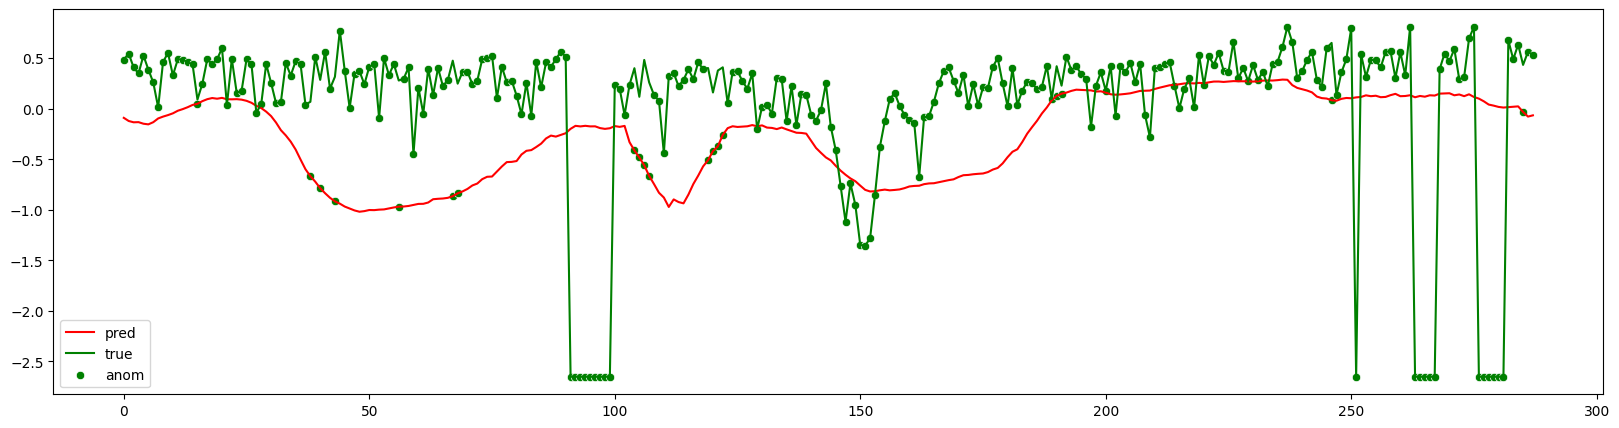

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred", color='red')
sns.lineplot(data=labs, label="true", color='green')
sns.scatterplot(data=anoms, label="anom", color='green') # where points are on actual graph, ignore; on preds, anomaly 

<Axes: >

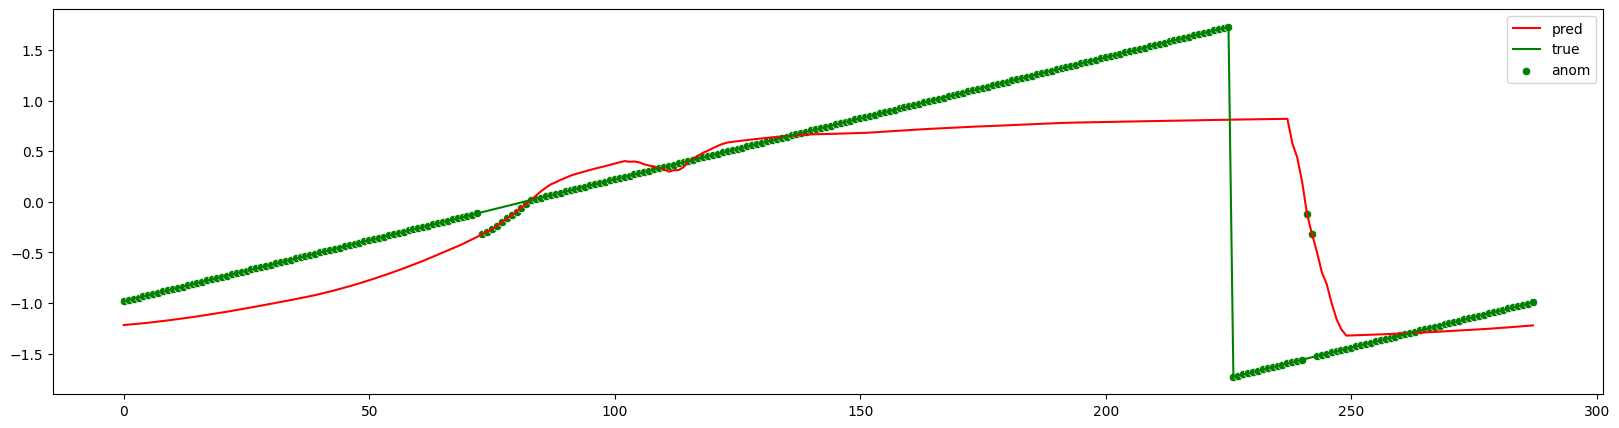

In [39]:
plt.figure(figsize=(20,5))
sns.lineplot(data=preds1, label="pred", color='red')
sns.lineplot(data=labs1, label="true", color='green')

sns.scatterplot(data=anoms1, label="anom", color='green') # where points are on actual graph, ignore; on preds, anomaly 

In [137]:
def subgraph_anomaly_detection(subgraph, curr_hour, pred_hour):
    #dimensions: subgraph-set, curr_hour-snapshot of graph during current hour (207x2x12), pred_hour-model predicted snapshot of graph for the next hour (207x12)
    curr_means = []
    for timestep in range(len(curr_hour[0][0])):
        temp = []
        for sensor in subgraph:
            temp.append(curr_hour[sensor][0][timestep])
        curr_means.append(np.mean(temp))
#     print("curr_means = ", curr_means)
    base = np.mean(curr_means)
#     print("base = ", base)
    dev = np.std(curr_means)
#     print("dev = ", dev)
    pred_means = []
    for timestep in range(len(curr_hour[0][0])):
        temp = []
        for sensor in subgraph:
            temp.append(pred_hour[sensor][timestep])
        pred_means.append(np.mean(temp))
#     print("pred_means = ", pred_means)
    anoms = []
    for i in pred_means:
        anoms.append(max(0.0, abs(i - base) - dev))
#     print("anoms = ", anoms)
#     print("norm = ", np.linalg.norm(anoms))
    return anoms
#     norm_anoms = []
#     if np.linalg.norm(anoms) == 0:
#         return anoms
#     else:
#         print("normalized anoms = ", norm_anoms)
#         for i in anoms:
#             norm_anoms.append(abs(i) / np.linalg.norm(anoms))
#         return norm_anoms

In [145]:
test_snapshot = train_dataset[1783]
predicted = model_speed(test_snapshot.x, test_snapshot.edge_index).detach().cpu().numpy()
print(subgraph_anomaly_detection(subgraphs[0], test_snapshot.x, predicted))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015515059, 0.0, 0.0, 0.0, 0.0]


In [146]:
def find_all_subgraph_anomalies(subgraphs, curr_hour, pred_hour):
    anomaly_list = []
    norm_anomaly_list = []
    mean_anomaly_list = {}
    max_val = 0.0
    for index, subgraph in enumerate(subgraphs):
        # ans = subgraph_anomaly_detection(i, train_dataset[1255].x, train_dataset[1255].y.permute(1, 0, 2)[0])
        ans = subgraph_anomaly_detection(subgraph, curr_hour, pred_hour)
        anomaly_list.append(ans)
        max_val = max(max_val,max(ans))
    print("Max : ",max_val)
    for index, anom in enumerate(anomaly_list):
        temp = 0.0
        count = 0
        print("INDEX ",index)
        print("Prev : ",anom)
        norm_anoms = [x/max_val for x in anom]
        print("Normalized :",norm_anoms)
        norm_anomaly_list.append(norm_anoms)
        for i in norm_anoms:
            if i > 0:
                temp += i
                count += 1
        if(count == 0):
            mean_anomaly_list[index] = temp
        else:
            mean_anomaly_list[index] = temp / count
    return (norm_anomaly_list, mean_anomaly_list)

In [147]:
anomaly_list, mean_anomaly_dict = find_all_subgraph_anomalies(subgraphs, train_dataset[1255].x, train_dataset[1255].y.permute(1, 0, 2)[0])

Max :  2.4355588
INDEX  0
Prev :  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19578332, 0.12980889, 0.18482572, 0.14389724, 0.1311071]
Normalized : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08038538, 0.053297374, 0.07588637, 0.059081815, 0.0538304]
INDEX  1
Prev :  [0.0, 0.014840178, 0.0, 0.0, 0.001232855, 0.0, 0.028447263, 0.0, 0.0, 0.0, 0.016077094, 0.010029547]
Normalized : [0.0, 0.006093131, 0.0, 0.0, 0.0005061898, 0.0, 0.011679973, 0.0, 0.0, 0.0, 0.0066009876, 0.004117965]
INDEX  2
Prev :  [0.378664, 0.43964693, 0.4487618, 0.418632, 0.527215, 0.51205957, 0.538283, 0.49335966, 0.4855468, 0.481966, 0.45331928, 0.50019574]
Normalized : [0.15547314, 0.18051173, 0.18425414, 0.17188334, 0.21646573, 0.21024315, 0.22101006, 0.20256528, 0.19935745, 0.19788723, 0.18612537, 0.20537207]
INDEX  3
Prev :  [0.0, 0.0, 0.0, 0.0, 0.0, 0.033835217, 0.0, 0.12523726, 0.020090573, 0.0045132563, 0.0, 0.0]
Normalized : [0.0, 0.0, 0.0, 0.0, 0.0, 0.013892178, 0.0, 0.05142034, 0.008248855, 0.0018530681, 0.0, 0.0]
IND

In [148]:
anomaly_list

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.08038538,
  0.053297374,
  0.07588637,
  0.059081815,
  0.0538304],
 [0.0,
  0.006093131,
  0.0,
  0.0,
  0.0005061898,
  0.0,
  0.011679973,
  0.0,
  0.0,
  0.0,
  0.0066009876,
  0.004117965],
 [0.15547314,
  0.18051173,
  0.18425414,
  0.17188334,
  0.21646573,
  0.21024315,
  0.22101006,
  0.20256528,
  0.19935745,
  0.19788723,
  0.18612537,
  0.20537207],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.013892178,
  0.0,
  0.05142034,
  0.008248855,
  0.0018530681,
  0.0,
  0.0],
 [0.014908462,
  0.0391748,
  0.015049546,
  0.0030574694,
  0.0,
  0.0,
  0.0,
  0.016954182,
  0.0,
  0.0053147925,
  0.043618936,
  0.010958156],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0,
  0.0,
  0.0,
  0.0,
  0.032768022,
  0.036718354,
  0.0022940566,
  0.06324203,
  0.16736148,
  0.20376097,
  0.23665358,
  0.30534095],
 [0.0,
  0.0007887758,
  0.0,
  0.0055856043,
  0.005867774,
  0.017292168,
  0.005867774,
  0.031964812,
  0

In [149]:
anomaly_list[16]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0051626824, 0.0]

In [150]:
subgraph_anomaly_detection(subgraphs[16], train_dataset[1255].x, train_dataset[1255].y.permute(1, 0, 2)[0])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.012574017, 0.0]

In [151]:
mean_anomaly_dict

{0: 0.06449626758694649,
 1: 0.0057996494113467635,
 2: 0.1942623903354009,
 3: 0.018853610090445727,
 4: 0.018629542755661532,
 5: 0.0,
 6: 0.13101743027800694,
 7: 0.00942844388919184,
 8: 0.11577600217424333,
 9: 0.21160248791178068,
 10: 0.08068863131726782,
 11: 0.04748063662555069,
 12: 0.01707309029168553,
 13: 0.022863180775727545,
 14: 0.05280654858797788,
 15: 0.009682850368941823,
 16: 0.005162682384252548,
 17: 0.0,
 18: 0.3508020649767584,
 19: 0.09555515615890424,
 20: 0.07921343296766281,
 21: 0.38072276119650766,
 22: 0.01495516657208403,
 23: 0.48743845735277447,
 24: 0.046534592285752296,
 25: 0.05546152085298672,
 26: 0.0,
 27: 0.03636047162581235,
 28: 0.047804778441786766,
 29: 0.02257774242510398,
 30: 0.24524201517407265,
 31: 0.7986473503212134,
 32: 0.036087105865590274,
 33: 0.32802888254324597,
 34: 0.017526074312627316,
 35: 0.2612238891112308,
 36: 0.006673387251794338,
 37: 0.04381401129066944,
 38: 0.0,
 39: 0.052284513134509325,
 40: 0.009499203064478934

In [152]:
def top_k_anomalous_subgraphs(k, mean_anomaly_dict):
    sorted_mean_anomaly_dict = sorted(mean_anomaly_dict.items(), key = lambda x : x[1], reverse = True)
    top_k_anomaly = [x for x, y in sorted_mean_anomaly_dict]
    return top_k_anomaly[0 : k]
    

In [153]:
anomalous_subgraphs = top_k_anomalous_subgraphs(5, mean_anomaly_dict)

In [154]:
anomalous_subgraphs

[31, 41, 52, 23, 21]

In [155]:
def micro_feature_analysis(anomalous_subgraphs, curr_hour, pred_hour):
    anomalous_analysis = {}
    for anomalous_subgraph in anomalous_subgraphs:
        anomalous_analysis[anomalous_subgraph] = {}
        for node in subgraphs[anomalous_subgraph]:
            anomalous_analysis[anomalous_subgraph][node] = []
            
            curr_hour_node_values = [float(x) for x in curr_hour[node][0]]
            curr_hour_node_mean = np.mean(curr_hour_node_values)
            curr_hour_node_dev = np.std(curr_hour_node_values)
            print("curr node values" , curr_hour_node_values)
            print("Curr node mean ", curr_hour_node_mean)
            print("Curr node dev", curr_hour_node_dev)
            
            pred_hour_node_values = [float(x) for x in pred_hour[node]]
            for step in range(len(pred_hour[0])): #the range is basically how many timesteps, which is 12 here
                anom = max(0.0, abs((pred_hour[node][step] - curr_hour_node_mean) - curr_hour_node_dev))
                print("predicted at time step", step, " is ", float(pred_hour[node][step]))
                if(anom):
                    anomalous_analysis[anomalous_subgraph][node].append(step)
                    
    return anomalous_analysis
                    
        

In [156]:
subgraphs[52]

{95, 125}

In [157]:
micro_feature_analysis(anomalous_subgraphs, train_dataset[1255].x, train_dataset[1255].y.permute(1, 0, 2)[0])

curr node values [-2.003406047821045, -1.9284976720809937, -2.058384656906128, -1.7738701105117798, -1.6625384092330933, -1.9408677816390991, -1.841906189918518, -1.6570404767990112, -1.9523544311523438, -1.6680362224578857, -1.6766756772994995, -1.9903485774993896]
Curr node mean  -1.8461605211098988
Curr node dev 0.14513278552985953
predicted at time step 0  is  -1.0412794351577759
predicted at time step 1  is  -1.2481367588043213
predicted at time step 2  is  0.09402981400489807
predicted at time step 3  is  0.7345311045646667
predicted at time step 4  is  0.6842650771141052
predicted at time step 5  is  0.3111955523490906
predicted at time step 6  is  0.6816142201423645
predicted at time step 7  is  0.632133424282074
predicted at time step 8  is  0.5393569469451904
predicted at time step 9  is  0.2507190704345703
predicted at time step 10  is  0.644503653049469
predicted at time step 11  is  0.6465651988983154
curr node values [-2.300290822982788, -2.3243439197540283, -2.2624928951

{31: {64: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 41: {108: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 52: {125: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
  95: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 23: {120: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
  25: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
 21: {148: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}}

In [94]:
from sklearn.metrics import mean_squared_error
from scipy.stats import zscore

In [166]:
def prediction_based_anomaly(next_real_values, next_predictions, previous_real_values, previous_predictions,node):
    
    print(next_real_values)
    # Calculate the residuals for the previous and next 12 timesteps
    previous_residuals = np.array(previous_predictions[node]) - np.array(previous_real_values[node])
    next_residuals = np.array(next_predictions[node]) - np.array(next_real_values[node])

    # Calculate z-scores for the residuals of the previous 12 timesteps
    z_scores_previous = zscore(previous_residuals)
    print(z_scores_previous,previous_residuals,next_residuals)
    # Define a threshold for anomaly detection based on the z-scores of the previous residuals
    anomaly_threshold = 0.5

    # Calculate z-scores for the residuals of the next 12 timesteps
    z_scores_next = zscore(next_residuals)
    print("ZSCORES NEXT",z_scores_next)

    # Identify anomalies in the residuals of the next 12 timesteps
    anomalies = np.where(np.abs(z_scores_next) > anomaly_threshold)[0]

    print("Previous Residuals:", previous_residuals)
    print("Next Residuals:", next_residuals)
    print("Anomalies (indices):", anomalies)
    

In [167]:
#anomalous_subgraphs, train_dataset[1255].x, train_dataset[1255].y.permute(1, 0, 2)[0]
#anomalous_subgraphs, curr_hour, pred_hour
#next_real_values, next_predictions, previous_real_values, previous_predictions

In [168]:
next_test_snapshot = train_dataset[1255]
cur_test_snapshot = train_dataset[1255 - 12]
prev_test_snapshot = train_dataset[1255 - 12 - 12]
cur_prediction = model_speed(prev_test_snapshot.x, prev_test_snapshot.edge_index).detach().cpu().numpy()
next_prediction = model_speed(cur_test_snapshot.x, cur_test_snapshot.edge_index).detach().cpu().numpy()
prediction_based_anomaly(next_test_snapshot.x.permute(1, 0, 2)[0], next_prediction ,cur_test_snapshot.x.permute(1, 0, 2)[0], cur_prediction, 95)

tensor([[ 0.6136,  0.6383,  0.6321,  ...,  0.6796,  0.6136,  0.5146],
        [ 0.5366,  0.5765,  0.4218,  ...,  0.5531,  0.4369,  0.5827],
        [-1.8110, -1.7677, -1.6625,  ..., -1.2007, -1.2172, -0.5121],
        ...,
        [-0.6784, -0.5740, -0.8337,  ..., -0.5355, -0.4184, -0.5183],
        [ 0.7290,  0.5579,  0.6569,  ...,  0.6466,  0.6277,  0.6136],
        [-1.9044, -1.9223, -1.4832,  ...,  0.4816,  0.4086,  0.4095]])
[-1.6207881   0.07720207 -1.698424    0.09510533 -1.2594358  -0.38056704
  0.68063176  0.12786116  1.1449823   0.9560118   1.3098434   0.5675794 ] [1.5980494 2.023091  1.5786155 2.0275726 1.6885033 1.9085021 2.174142
 2.035772  2.2903783 2.2430751 2.3316464 2.1458426] [1.4135609  1.5667722  1.450667   1.5763931  0.93148327 1.1081504
 1.2653254  1.3689349  1.4105922  1.247931   1.5842354  1.0684061 ]
ZSCORES NEXT [ 0.3968083   1.1487008   0.5789087   1.1959159  -1.9690123  -1.1020094
 -0.33066472  0.17780393  0.3822394  -0.41602874  1.2344024  -1.2970564 ]
Prev

In [169]:
import numpy as np

# Sample data
timestamps = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
feature_values = np.array([10, 12, 14, 21, 23, 26, 12, 9, 11, 15])

# Calculate slope
time_diff = np.diff(timestamps)
value_diff = np.diff(feature_values)
slopes = value_diff / time_diff

# Define a threshold for anomaly detection (you can adjust this threshold)
anomaly_threshold = 2

# Identify anomalies
anomalies = np.where(slopes > anomaly_threshold)[0]

print("Slopes:", slopes)
print("Anomalies (indices):", anomalies)

Slopes: [  2.   2.   7.   2.   3. -14.  -3.   2.   4.]
Anomalies (indices): [2 4 8]


In [172]:
print(value_diff)

[  2   2   7   2   3 -14  -3   2   4]
